## Овечкина Лидия

Необходимо предсказать клас y на фичах a, b, c.  

Задание 1. Построить модель Pymc с множественной логистической регрессией для решения задачи. Предсказать класс на test_clf.  

Задание 2. Построить модель Pymc с порождающим множественным логистическим классификатором для решения задачи. Предсказать класс на test_clf.  

Каждое задание оценивается в 10 баллов  

## Задание 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math

In [3]:
import scipy.stats as stats
import pymc as pm
import arviz as az

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
#!pip install pymc

In [6]:
train_data = pd.read_csv('classify/train_clf.csv')
test_data = pd.read_csv('classify/test_clf.csv')

In [7]:
columns = train_data.columns[:-1]
x_o = train_data[columns].values
x_means = x_o.mean(axis=0)
x_1 = (x_o - x_means)/x_o.std()
y_1 = [1 if marker == 1.0 else 0 for marker in train_data.y] 

In [8]:
with pm.Model() as model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(columns))

    mu = alpha_tmp + pm.math.dot(x_1, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, x_means))
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * (x_1[:, 0] + x_means[0]))

    yl = pm.Bernoulli('yl', p=theta, observed=y_1)

    trace = pm.sample(2000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tmp, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


In [9]:
varnames = ['alpha', 'beta', 'bd']
az.summary(trace, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,25.196,4.011,17.880,32.818,0.044,0.032,8526.0,6058.0,1.0
beta[0],-2.611,0.723,-4.000,-1.278,0.010,0.007,5118.0,5321.0,1.0
beta[1],-2.471,0.712,-3.780,-1.061,0.010,0.007,4981.0,5872.0,1.0
beta[2],-0.165,0.651,-1.415,1.037,0.010,0.007,4587.0,5204.0,1.0
bd[0],4.661,0.771,3.808,5.355,0.010,0.007,4249.0,5168.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],5.969,0.523,5.417,6.616,0.007,0.005,5313.0,5599.0,1.0
bd[96],4.758,0.686,3.987,5.383,0.009,0.006,4311.0,5133.0,1.0
bd[97],4.481,0.932,3.482,5.315,0.012,0.009,4188.0,4931.0,1.0
bd[98],6.354,0.858,5.549,7.350,0.011,0.008,4807.0,5579.0,1.0


In [10]:
az.summary(trace, var_names=['alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,25.196,4.011,17.880,32.818,0.044,0.032,8526.0,6058.0,1.0
beta[0],-2.611,0.723,-4.000,-1.278,0.010,0.007,5118.0,5321.0,1.0
beta[1],-2.471,0.712,-3.780,-1.061,0.010,0.007,4981.0,5872.0,1.0
beta[2],-0.165,0.651,-1.415,1.037,0.010,0.007,4587.0,5204.0,1.0


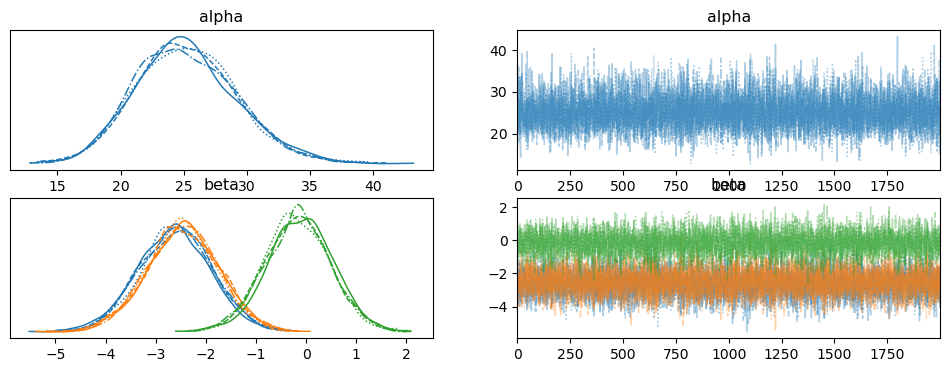

In [11]:
az.plot_trace(trace, var_names = ['alpha', 'beta'],compact=True);

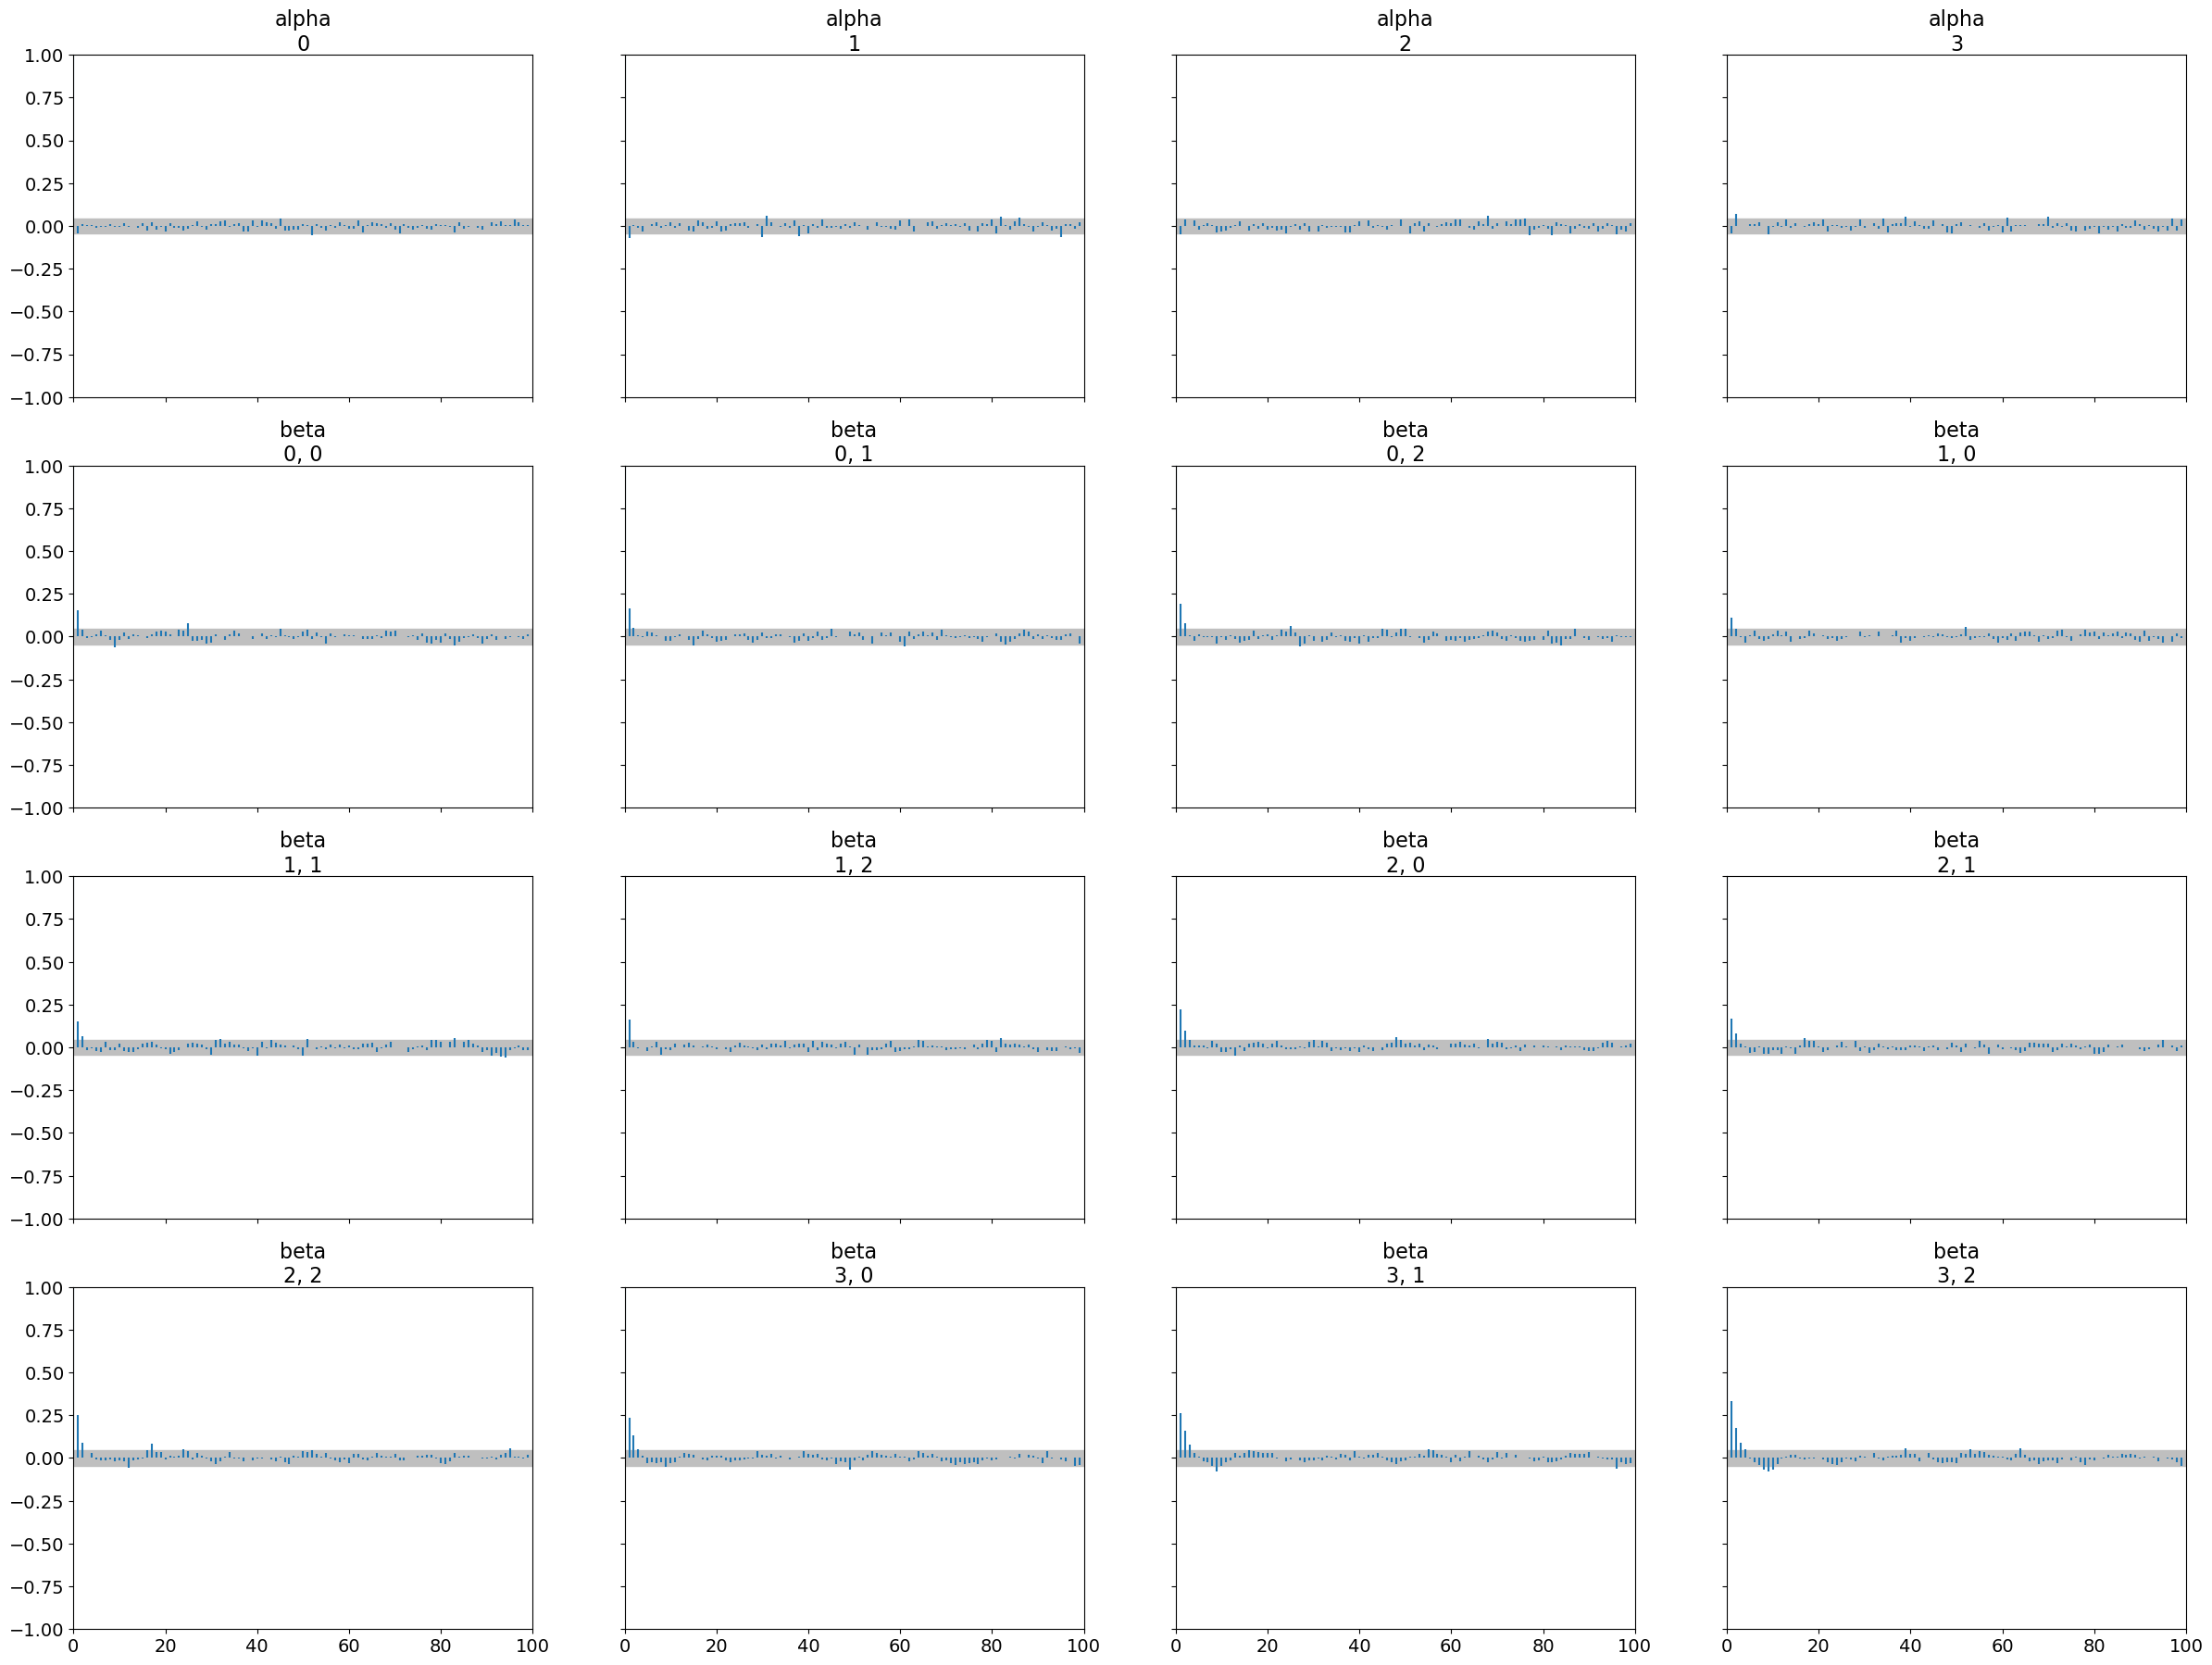

In [12]:
az.plot_autocorr(trace, ['alpha', 'beta']);

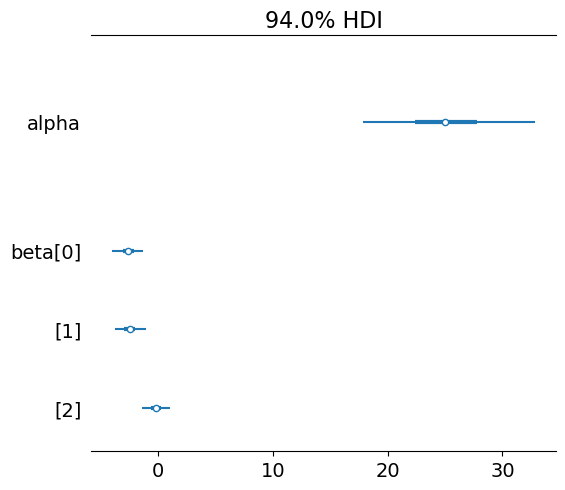

In [13]:
az.plot_forest(trace, var_names=['alpha', 'beta'], combined=True);

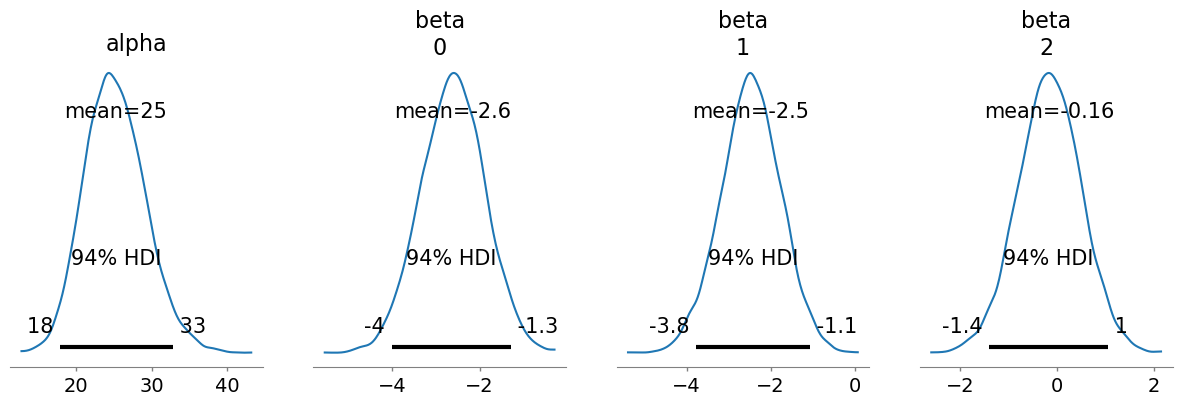

In [14]:
az.plot_posterior(trace, var_names=['alpha', 'beta'], figsize=(15, 4));

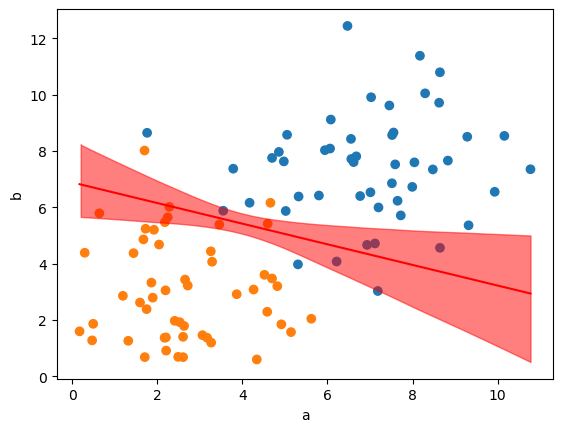

In [15]:
idx = np.argsort(x_1[:, 0])
bd = trace.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_o[:, 0], x_o[:, 1], c=[f'C{i}' for i in y_1]) 

plt.plot(x_o[:, 0][idx], bd, color='r')
az.plot_hdi(x_o[:, 0], trace.posterior['bd'], color='r')

plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

In [16]:
alpha_tmp = trace.posterior['alpha_tmp'].mean().item()
beta_1 = trace.posterior['beta'].mean(axis=0)[0].mean().item()
beta_2 = trace.posterior['beta'].mean(axis=0)[1].mean().item()

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

mu = alpha_tmp + beta_1*x_1[:, 0] +  beta_2*x_1[:, 1]
y_train_pred = sigmoid(mu) > 0.5

In [18]:
accuracy = accuracy_score(y_1, y_train_pred)
print("Accuracy:", accuracy)

Accuracy: 0.95


In [19]:
conf_matrix = confusion_matrix(y_1, y_train_pred)
print(conf_matrix)

[[47  2]
 [ 3 48]]


In [20]:
x_test_o = test_data[columns].values
x_test = (x_test_o - x_means) / x_o.std()

In [21]:
μ = alpha_tmp + beta_1*x_test[:, 0] +  beta_2*x_test[:, 1]
y_pred = sigmoid(mu) > 0.5

In [22]:
y_pred

array([False, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True, False, False,
       False, False, False,  True,  True,  True, False, False,  True,
        True, False, False,  True, False,  True,  True, False,  True,
       False,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
       False, False,  True,  True, False, False,  True,  True,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True,  True,  True,  True, False,  True, False, False,
        True,  True, False,  True, False,  True, False, False,  True,
       False])

In [23]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.45

## Задание 2

Построить модель Pymc с порождающим множественным логистическим классификатором для решения задачи. Предсказать класс на test_clf.

In [24]:
df = train_data
y_0 = pd.Categorical(df['y']).codes
column = 'a'
x_0 = df[column].values

with pm.Model() as lda:
    mu = pm.Normal('μ', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('σ', 10, shape=2)
    category_0 = pm.Normal('category_0', mu=mu[0], sigma=sigma[0], observed=x_0[y_0 == 0])
    category_1 = pm.Normal('category_1', mu=mu[1], sigma=sigma[1], observed=x_0[y_0 == 1])

    bd = pm.Deterministic('bd', (mu[0] + mu[1]) / 2)
    trace_lda = pm.sample(4000, chains=4, cores=4, tune=2000, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 18 seconds.


In [25]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],6.912,0.266,6.436,7.439,0.002,0.001,16243.0,11986.0,1.0
μ[1],2.659,0.198,2.301,3.047,0.001,0.001,17573.0,11338.0,1.0
σ[0],1.847,0.194,1.504,2.217,0.002,0.001,16136.0,12392.0,1.0
σ[1],1.399,0.145,1.148,1.681,0.001,0.001,16293.0,11582.0,1.0
bd,4.785,0.166,4.479,5.108,0.001,0.001,16408.0,11641.0,1.0


In [26]:
μ_11 = trace_lda.posterior['μ'][:, 0].mean()
μ_12 = trace_lda.posterior['μ'][:, 1].mean()

In [27]:
predictions = []
for i in range(len(x_1)):
    x_val = x_1[i][0] 
    if x_val * μ_11 > x_val * μ_12:
        predictions.append(0)  # Класс 0
    else:
        predictions.append(1)  # Класс 1

print("Предсказания:", predictions)

Предсказания: [0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]


In [28]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, predictions)

0.49